In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
import FinanceDataReader as fdr

data = fdr.DataReader('005930')

data.describe()

,Open,High,Low,Close,Volume,Change
count,6000.000000,6000.000000,6000.00000,6000.000000,6.000000e+03,5999.000000
mean,25330.020000,25587.571167,25065.78550,25349.611167,3.551613e+06,0.000906
std,20924.004596,21094.403488,20741.95584,20908.349699,7.142212e+06,0.023346
min,0.000000,0.000000,0.00000,1197.000000,0.000000e+00,-0.137566
25%,9696.750000,9830.000000,9550.00000,9757.500000,2.935750e+05,-0.011418
50%,16690.000000,16910.000000,16500.00000,16710.000000,4.948560e+05,0.000000
75%,38000.000000,38407.500000,37705.00000,38175.000000,1.078807e+06,0.012257
max,90300.000000,96800.000000,89500.00000,91000.000000,9.030618e+07,0.150000


In [3]:
data.isna().sum() # Change 열에 결측치 하나 존재. 하지만 종가만 예측할 것이기 때문에 무시

Open      0
High      0
Low       0
Close     0
Volume    0
Change    1
dtype: int64

In [4]:
data[data['Change'].isna()] # 1998-11-26 시점의 Change 데이터 결측

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-11-26,1340,1358,1306,1312,678740,NaN


In [5]:
stock = data['Close']

In [6]:
stock

Date
1998-11-26     1312
1998-11-27     1283
1998-11-28     1318
1998-11-30     1276
1998-12-01     1197
              ...  
2023-03-08    60300
2023-03-09    60100
2023-03-10    59500
2023-03-13    60000
2023-03-14    59000
Name: Close, Length: 6000, dtype: int64

In [53]:
stock = stock['2020-03-11':] # 2020년 3월 11일(수) ~ 2023년 3월 14일(화)

In [149]:
Train = stock[:'2022-03-14']
Test = stock['2022-03-15':]

### Box-Jenkins 방법

### 1. 식별
- 그래프가 정상성(Stationary)을 띄는가?
> 정상성을 나타내는 시계열은 해당 시계열이 관측된 시간과 무관하다. 
> 
> 따라서, 추세나 계절성이 있는 시계열은 정상성을 나타내지 않는다.(추세와 계절성은 서로 다른 시간에 시계열의 값에 영향을 줄 것이기 때문)

Text(0, 0.5, 'Stock')

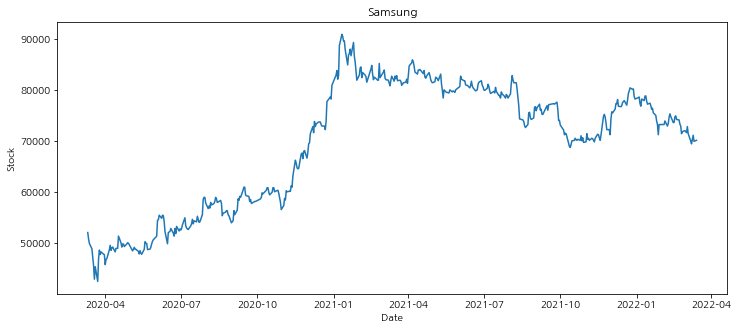

In [150]:
# 목측법: 시계열 데이터를 그래프로 그려서 추세, 계절성과 주기 등을 파악

plt.figure(figsize=(12, 5))

fig = plt.plot(Train)

plt.title('Samsung')
plt.xlabel('Date')
plt.ylabel('Stock')


그래프로 그려봤을 때, 딱히 정상성을 나타낸다고 보이지는 않는다.

그럼 자기 상관 그래프(Auto-correlation function graph)를 그려보자

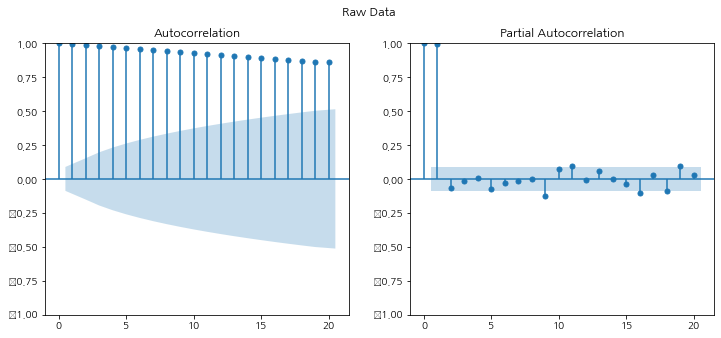

In [151]:
# 식별
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('Raw Data')
plot_acf(Train.values.squeeze(), lags = 20, ax = ax[0])
plot_pacf(Train.values.squeeze(), lags = 20, ax = ax[1])

plt.show()

Auto-Correlation Function graph를 그려봤을 때 거의 모든 시차에 대해 자기 상관 계수가 허용 범위를 초과하고 있으므로 비정상성을 나타낸다고 할 수 있다.

또한, Partial Auto-Correlation Function graph를 그려봤을 때 t 시점과 t-1 시점의 상관계수가 높음을 확인할 수 있다. <br>이를 통해 이 모형은 1차 자기 회귀 모형으로 모델링할 수 있을 것으로 생각된다.

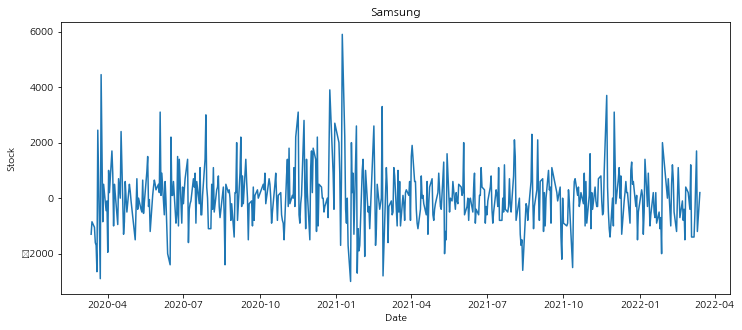

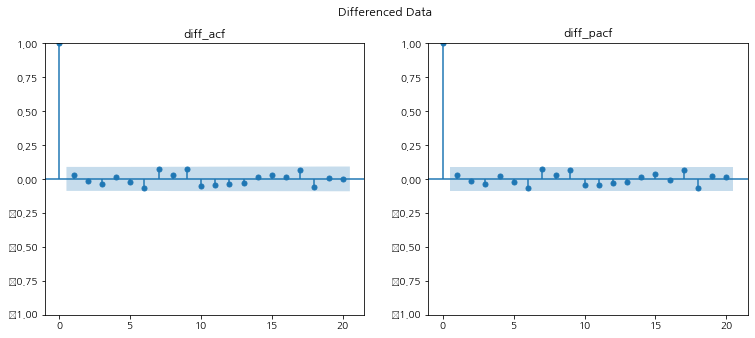

In [152]:
stock_diff = Train.diff(periods=1).iloc[1:]

plt.figure(figsize=(12, 5))

fig = plt.plot(stock_diff)

plt.title('Samsung')
plt.xlabel('Date')
plt.ylabel('Stock')

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12.6,5))
fig.suptitle('Differenced Data')

plot_acf(stock_diff.values.squeeze(), lags = 20, ax = ax[0])
ax[0].set_title('diff_acf')

plot_pacf(stock_diff.values.squeeze(), lags = 20, ax = ax[1])
ax[1].set_title('diff_pacf')

plt.show() # 정상성을 나타내는 것으로 보인다.

1차 차분했을 때 정상성을 나타내는 것처럼 보인다. 따라서, ARIMA(p, 1, q)를 생각할 수 있다.

acf가 Lag 0 이후로 대부분 파란 구간 안에 있으므로 MA(0) 모형을 잠정 모형으로 판단한다.

pacf가 Lag 0 이후로 대부분 파란 구간 안에 있으므로 AR(0) 모형을 잠정 모형으로 판단한다.

ARIMA(0, 1, 0)

In [153]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(stock_diff.values)
print('ADF Statistics: %f' %adf_result[0])
print('p-value: %f' %adf_result[1])
print('Critical values: ')
for key, value in adf_result[4].items():
    print("\t%s: %.3f" %(key, value))

ADF Statistics: -21.629763
p-value: 0.000000
Critical values: 
	1%: -3.444
	5%: -2.867
	10%: -2.570


p-value가 0.05 미만이므로 귀무가설을 기각할 수 있다. 따라서, 1차 차분한 그래프는 정상성을 나타낸다고 할 수 있다.

In [166]:
import statsmodels.api as sm

# (AR = 9, 차분 =1, MA=9) 파라미터로 ARIMA 모델을 학습한다.
model = sm.tsa.arima.ARIMA(Train.values, order = (0,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  495
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4160.650
Date:                Tue, 14 Mar 2023   AIC                           8323.300
Time:                        20:27:20   BIC                           8327.503
Sample:                             0   HQIC                          8324.950
                                - 495                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.208e+06   5.07e+04     23.836      0.000    1.11e+06    1.31e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               169.83
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.71
Prob(H) (two-sided):                  0.21   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

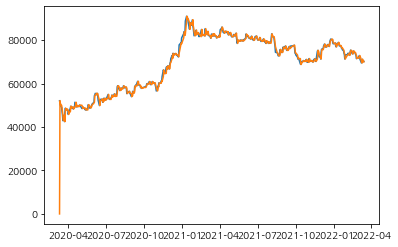

In [167]:
res = pd.DataFrame(model_fit.predict(), index=Train.index)
plt.plot(Train)
plt.plot(res)

In [181]:
from pmdarima import auto_arima

auto_model = auto_arima(y = Train        # 데이터
                      , d = 1            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8324.751, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8326.447, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8326.443, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8323.300, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8324.901, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.335 seconds


In [182]:
model = auto_arima(Train, d = 1, seasonal = False, trace = True)
model.fit(Train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8332.478, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8324.751, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8326.447, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8326.443, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8323.300, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8324.901, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.705 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [183]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  495
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4160.650
Date:                Tue, 14 Mar 2023   AIC                           8323.300
Time:                        20:32:14   BIC                           8327.503
Sample:                             0   HQIC                          8324.950
                                - 495                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.208e+06   5.07e+04     23.836      0.000    1.11e+06    1.31e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               169.83
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.71
Prob(H) (two-sided):                  0.21   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [195]:
auto_predict = pd.DataFrame(auto_model.predict(n_periods=len(Test)))
auto_predict.index = Test.index

c:\Users\ms964\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [197]:
auto_predict.columns = ['Prediction']

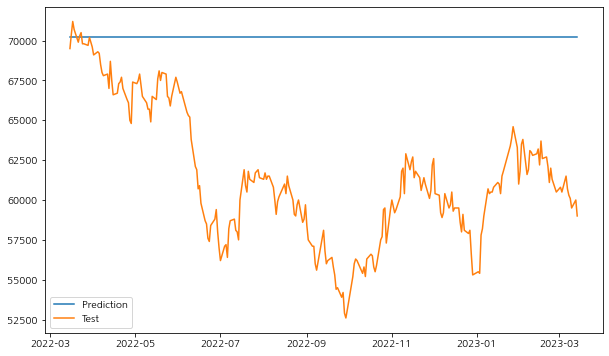

In [198]:
plt.figure(figsize=(10,6))
plt.plot(auto_predict, label="Prediction") # 예측 값
plt.plot(Test, label="Test") # 실제 값
plt.legend()
plt.show()

정확한 예측을 하지 못하는 것으로 판단되었다.

이것 외에도 1년간의 종가를 예측해보았는데, 예측한 값들이 모두 동일한 문제가 발생하였다.

이는 데이터에 특정한 주기나 추세가 없기 때문에 AIC로 모형을 최적화하는 과정에서 의미있는 자기 상관이나 이동 평균을 찾기 어려웠기 때문이다.

본 과제에서 찾은 모형은 ARIMA(0, 1, 0)으로, 1차 차분 시 백색 잡음인 모형이다. 이는 아래 식처럼 상수항이 없는 임의 보행 모형을 따른다는 것을 알 수 있다.

$y_t - y_{t-1} = \epsilon_t$

$y_t = y_{t-1} + \epsilon_t, \epsilon_t \sim N(0, \sigma^2)$

예측을 할 때, innovative term인 $\epsilon_t$의 기댓값이 0이기 때문에 이 부분을 0으로 대체한다. 따라서, 예측치들은 모두 마지막 값으로 대체됨을 알 수 있다. 

***~~이거 보고 사면 망할 것 같다는 생각이 들었다.~~***

In [199]:
def forecast_one_step():
    fc = model.predict(n_periods=1) # 한 스텝씩!
    conf_int = model.conf_int()
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [200]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in Test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(pd.Series(new_ob))

c:\Users\ms964\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [206]:
predict = pd.DataFrame({"test": Test, "pred": y_pred})

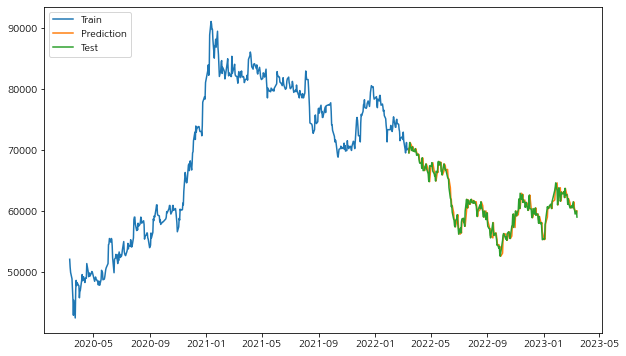

In [207]:
plt.figure(figsize=(10,6))
plt.plot(Train, label="Train") # Train 데이터 
plt.plot(predict['pred'], label="Prediction") # 모델이 예상한 그래프 
plt.plot(Test, label="Test") # 실제 가격 그래프 
plt.legend(loc='upper left')
plt.show()

In [211]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

RMSE = mean_squared_error(Test, predict['pred'])**0.5
print("RMSE : " , RMSE) 

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MAPE : " , MAPE(Test, predict['pred'])) # MAPE가 1.1%로, 매우 잘 적합되었음을 알 수 있다.

RMSE :  900.5130175511714
MAPE :  1.1464559802065992


참고 자료: https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/

auto_arima를 이용할 때는 임의 보행 모형을 따른다는 사실 때문에 모델이 잘 적합되지 않았다.<br>이를 해결하기 위해 1일 전 데이터 값을 예측할 때마다 업데이트 해주어 예측을 했더니 만족할만한 결과가 나왔다.